The script demonstrates how the code can be used with a toy example (see also [this blogpost](https://andreasloukas.blog/2018/11/05/multilevel-graph-coarsening-with-spectral-and-cut-guarantees/)).

The code accompanies paper [Graph reduction with spectral and cut guarantees](http://www.jmlr.org/papers/volume20/18-680/18-680.pdf) by Andreas Loukas published at JMLR/2019 ([bibtex](http://www.jmlr.org/papers/v20/18-680.bib)).

This work was kindly supported by the Swiss National Science Foundation (grant number PZ00P2 179981).

15 March 2019

[Andreas Loukas](https://andreasloukas.blog)

[![DOI](https://zenodo.org/badge/175851068.svg)](https://zenodo.org/badge/latestdoi/175851068)

Released under the Apache license 2.0

In [1]:
!pip install networkx
!pip install sortedcontainers

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
import sys
sys.path.append('./coarsening_lib')
from graph_coarsening.coarsening_utils import *
import graph_coarsening.graph_utils

import numpy as np
import scipy as sp

import matplotlib
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D


import networkx as nx
import pygsp as gsp
from pygsp import graphs
gsp.plotting.BACKEND = 'matplotlib'


import pickle
import os
import time
from  scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split

In [5]:
from geno_to_gso import geno_to_gso


## Make Yeast Data

In [6]:
path_to_geno = 'data/yeast/geno_yeast_congored.npy'
path_to_pheno = 'data/yeast/pheno_yeast_congored.npy'
del_rate=0.98
sampling_ratio = 0.1

X = np.load(path_to_geno, allow_pickle = True)
y = np.load(path_to_pheno, allow_pickle = True)
print(X.shape)
print(y.shape)

(979, 11623)
(979,)


In [7]:
gso, _ =geno_to_gso(X, dist="corr", norm_method = "eigenvalue", sparse_method = "thresh",
                     del_rate = del_rate)
print(gso.shape)

Sparsification.... DONE. Percentage of non zero values in gso: 2.0000003108943396
Computing maximum eigenvalue, this may take a while.
Maximum eigenvalue is 240.08960532998296.
Computation lasted 12.59 seconds.
(11623, 11623)


In [8]:
### Train Val Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15)

print("Standardizing markers.")
mean = np.mean(X_train, axis = 0).reshape((1, -1))
std = np.std(X_train, axis = 0).reshape((1, -1))
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
X_val = (X_val - mean)/std

print("Standardizing phenotypes.")
mean = np.mean(y_train, axis = 0)
std = np.std(y_train, axis = 0)
y_train = (y_train - mean)/std
y_test = (y_test - mean)/std
y_val = (y_val - mean)/std
        
N = X_train.shape[1]
num_samples = int(sampling_ratio*X_train.shape[1])
print(f"sampling {num_samples} out of {N} SNPs")
indexes = np.random.choice(N, size=num_samples, replace=False)
gso = gso[indexes, :]
gso = gso[:,  indexes]
X_train = X_train[:, indexes]
X_val = X_val[:, indexes]
X_test = X_test[:, indexes]

Standardizing markers.
Standardizing phenotypes.
sampling 1162 out of 11623 SNPs


In [9]:
S = gso
S = (S > 0).astype(int)
print(f"GSO shape {S.shape}")
np.fill_diagonal(S, 0)
S = np.triu(S)+np.triu(S).T

GSO shape (1162, 1162)


### Construct the graph ## 

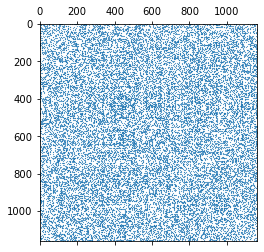

In [10]:
S= coo_matrix(S)
W =  S
G = graphs.Graph(W=W)

if not hasattr(G, 'coords'): 
    try:
        graph = nx.from_scipy_sparse_matrix(G.W)
        pos = nx.nx_agraph.graphviz_layout(graph, prog='neato')  
        G.set_coordinates(np.array(list(pos.values()))) 
    except ImportError:
        G.set_coordinates()
    G.compute_fourier_basis() # this is for convenience (not really needed by coarsening)   
N = G.N
L = G.L.toarray()

plt.spy(G.W, markersize=0.2);

### Do some coarsening

* Possible methods supported are: 'variation_edges', 'variation_neighborhood', 'algebraic_JC', 'heavy_edge', 'affinity_GS'
* $r = 1 - n/N$ is the dimensionality reduction ratio
* $k$ is the size of the subspace we are interested in
* $k_{max}$ should be set to be larger or equal to $k$. It allows us to measure the quality of coarsening over subspaces larger than $k$.

In [11]:
method = 'variation_neighborhood' 

# Parameters
r    = 0.5 # the extend of dimensionality reduction (r=0 means no reduction)
k    = 100
kmax = int(3*k)
t0 = time.time()        
C, Gc, Call, Gall = coarsen(G, K=k, r=r, method=method) 
metrics = coarsening_quality(G, C, kmax=kmax)
n = Gc.N

t1 = time.time()
print(f"Coarsening took {t1-t0} seconds")
print('{:16} | r: {:1.4}, nedges: {}, levels: {}, epsilon: {:1.4}'.format(method, metrics['r'], metrics['m'], len(Call), metrics['error_subspace'][k-1]))

./coarsening_lib/graph_coarsening/coarsening_utils.py:530: RuntimeWarning: invalid value encountered in double_scalars
  return np.linalg.norm(B.T @ L @ B) / (nc - 1)
./coarsening_lib/graph_coarsening/coarsening_utils.py:264: RuntimeWarning: divide by zero encountered in power
  linv = l ** (-0.5)
./coarsening_lib/graph_coarsening/coarsening_utils.py:264: RuntimeWarning: invalid value encountered in power
  linv = l ** (-0.5)
./coarsening_lib/graph_coarsening/coarsening_utils.py:288: RuntimeWarning: divide by zero encountered in true_divide
  metrics["error_eigenvalue"] = np.abs(l[:kmax] - lc[:kmax]) / l[:kmax]
./coarsening_lib/graph_coarsening/coarsening_utils.py:305: RuntimeWarning: invalid value encountered in matmul
  M = S @ Pi @ U @ np.diag(linv)


Coarsening took 108.69834661483765 seconds
variation_neighborhood | r: 0.5, nedges: 4653, levels: 1, epsilon: nan


### Visualize the sequence of coarsening levels

* $c+1$ graphs are plotted in total. The leftmost is the original graph and the rightmost is the final coarse graph. 
* Colors are used to indicate the size of each contraction set $C$: 
    * green is for $|C|=2$  blue is for $|C|=3$, red is for $|C|=4$, and yellow for $|C|>4$


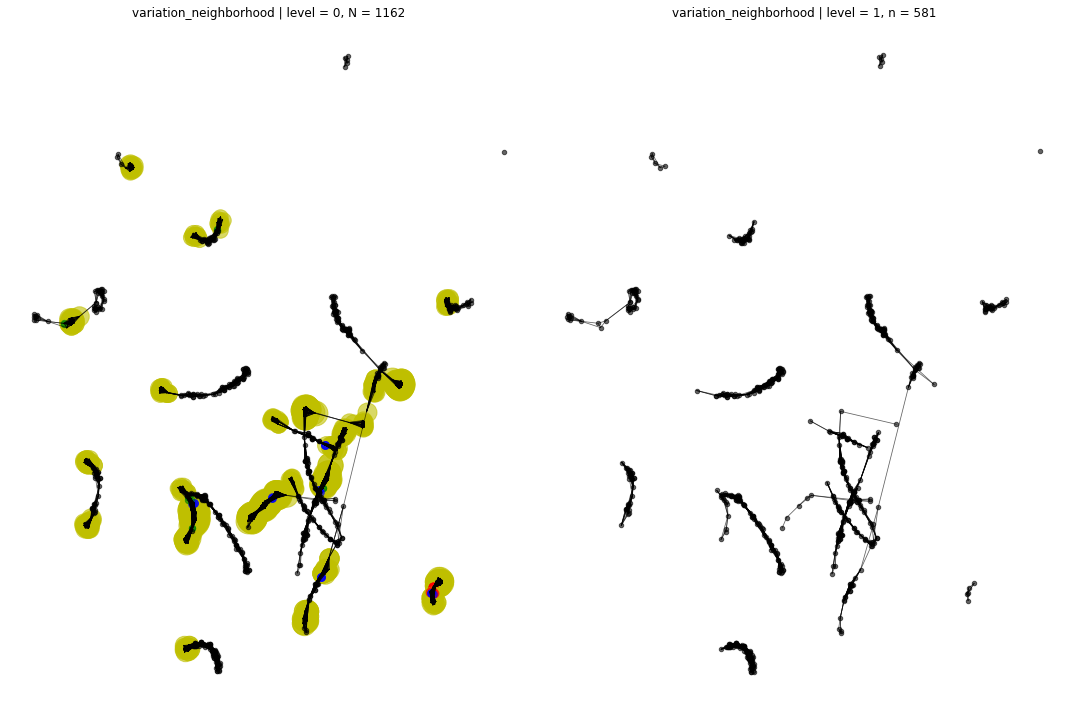

In [12]:
plot_coarsening(Gall, Call, size=5, alpha=0.6, title=method);

### Various metrics for coarsening quality

* $\epsilon$ is the restricted similarity constant such that, for every $x \in span(U_k)$ we have $$(1 - \epsilon) x^\top L x \leq x_c^\top L_c x_c \leq (1+\epsilon) x^\top L x $$   
* the eigenvalue error is defined (for every $i = 1, \ldots, k, \ldots, kmax$ as $\frac{\lambda_i - \tilde{\lambda}_i}{\lambda_i}$
* the angle matrix contains the angles between the eigenvectors of $L$ (y-axis) and the lifted eigenvectors of $L_c$. The closer to counter-diagonal it is, the better.

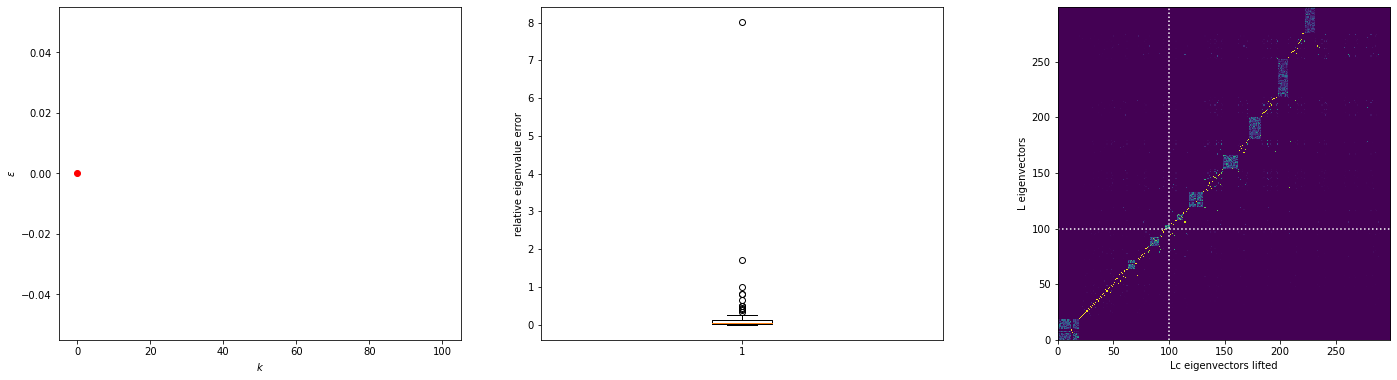

In [13]:
size = 2.04; fig, axes = plt.subplots(1, 3, figsize=(4*size*3, 3*size)); lineWidth = 1

axes[0].plot(np.arange(kmax), np.abs(metrics['error_subspace']), 'or-') 
axes[0].set_xlabel('$k$'); axes[0].set_ylabel('$\epsilon$')
axes[0].plot( [k, k], [0, max(metrics['error_subspace'])], ':k') 

axes[1].boxplot(np.abs(metrics['error_eigenvalue'])) 
axes[1].set_ylabel('relative eigenvalue error')

axes[2].imshow(abs(metrics['angle_matrix'][:,0:kmax]) )
axes[2].plot( [k, k], [0, kmax], ':w') 
axes[2].plot( [0, kmax], [k, k], ':w') 
axes[2].plot( [0, N], [n-1, n-1], ':w') 
axes[2].set_xlim([0, kmax-1])
axes[2].set_ylim([0, kmax-1])
axes[2].set_xlabel('Lc eigenvectors lifted'); axes[2].set_ylabel('L eigenvectors');

### Coarsen and lift a vector

signal mse: 0.1780717804510915


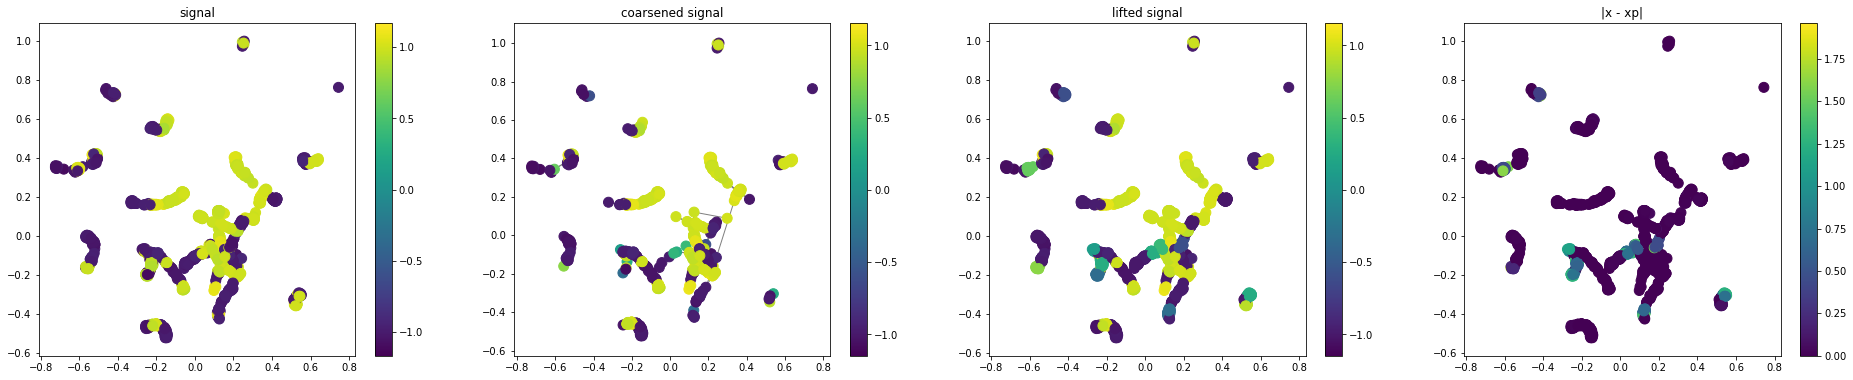

In [19]:
size = 2.04; fig, axes = plt.subplots(1, 4, figsize=(4*size*4, 3*size)); lineWidth = 1

# a training sample 
x = X_train[0]

# coarsen it 
xc = coarsen_vector(x, C)


# lift it 
xp = lift_vector(xc, C)
print('signal mse: {}'.format(np.mean((x - xp)**2)))

G.plot_signal(x, ax=axes[0], plot_name='signal')
G.plot_signal(xp, ax=axes[2], plot_name='lifted signal')
Gc.plot_signal(xc, ax=axes[1], plot_name='coarsened signal')
# difference
G.plot_signal(np.abs(x-xp), ax=axes[3], plot_name='|x - xp|')



In [15]:
print(x.shape)

(1162,)


In [16]:
print(xc.shape)

(581,)


In [17]:
print(C.shape)

(581, 1162)
